In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as axisartist
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from itertools import combinations
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
from sklearn.linear_model import LinearRegression
import os
from IPython.core.display import Image, display


C:\Users\shaha\Miniconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### LANL Earthquake Prediction competiotion overview

**"Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.<br>
In this competition, you will address when the earthquake will take place. Specifically, you’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data"**<br>
https://www.kaggle.com/c/LANL-Earthquake-Prediction

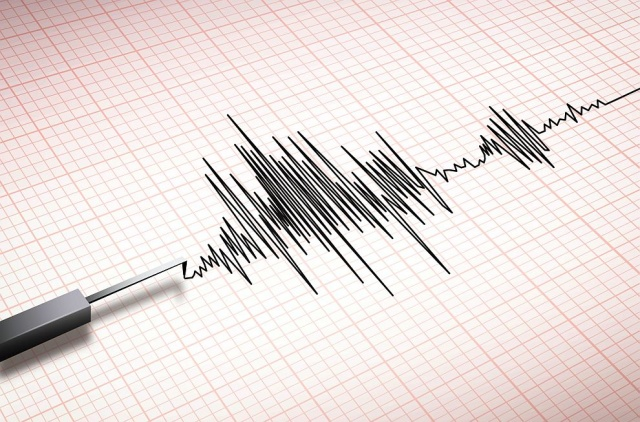

In [2]:
display(Image('https://www.novinite.com/media/images/2018-02/photo_verybig_187820.jpg'))

### Data Description


**The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure).
<br><br>
The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.
<br><br>
For each seg_id in the test folder, you should predict a single time_to_failure corresponding to the time between the last row of the segment and the next laboratory earthquake**

https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

# Problem Statement

### predict the time remaining before laboratory earthquakes occur


**Work Flow**
1. Reading the Dataset
2. Exploratory data analysis
3. Feature Engineering/Extraction
4. Feature selection (Remove highly correlate features)
4. Establish a baseline
5. Compare several machine learning models with grid search (RandomForestRegressor,KNeighborsRegressor,SVR)
6. Trying to improve model with normalization
7. Predict on test set with the best model


## Reading the Dataset

In [3]:
df= pd.read_csv('train.csv')

In [4]:
pd.options.display.precision = 20

In [5]:
print(df.columns)
print(df.shape)
df.head()

Index(['acoustic_data', 'time_to_failure'], dtype='object')
(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.46909998320000001470
1,6,1.46909998210000014573
2,8,1.46909998099999983268
3,5,1.46909997990000018575
4,8,1.46909997879999987269


### Checking For missing values

In [6]:
df.isna().sum()

acoustic_data      0
time_to_failure    0
dtype: int64

In [7]:
df.describe()

,acoustic_data,time_to_failure
count,6.29145480000000000000e+08,6.29145480000000000000e+08
mean,4.51946757370012441868e+00,5.67829171297885437752e+00
std,1.07357072495109644450e+01,3.67269651944357766737e+00
min,-5.51500000000000000000e+03,9.55039631660000104887e-05
25%,2.00000000000000000000e+00,2.62599699605000003189e+00
50%,5.00000000000000000000e+00,5.34979774124999973850e+00
75%,7.00000000000000000000e+00,8.17339550777500001288e+00
max,5.44400000000000000000e+03,1.61073999999999983856e+01


### We have no records with missing values

## Notes and Initial insights after basic summaries on the data
* We have 629145480 records
* The data has 2 columns: 
accoustic_data: accoustic signal measured in the laboratory experiment<br>
time_to_failure: time until a failure will occurs.
* We have no missing values
* values range:
accoustic_data: from ~-5515 to ~5444<br>
time_to_failure:~0 to ~16


# Exploratory Data Analysis

In [8]:
"""
The function gets 4 parameters:
df-Data Frame
fromIndex-start index
toIndex-end index
steps-steps size

The function plots 'acoustic_data','time_to_failure' (2 y axis) from 'fromIndex' to 'toIndex' by steps
"""
def plotSignal(df,fromIndex=0,toIndex=df.shape[0],steps=1):
    
    fig, host = plt.subplots(figsize=(20,10))
    fig.subplots_adjust(right=0.75)
    par1 = host.twinx()
    p1, = host.plot(df['acoustic_data'].values[fromIndex:toIndex:steps], "b-", label="acoustic_data")
    p2, = par1.plot(df['time_to_failure'].values[fromIndex:toIndex:steps], "r-", label="time_to_failure")
    host.set_ylabel("acoustic_data")
    par1.set_ylabel("time_to_failure")
    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)
    lines = [p1, p2]
    host.legend(lines, [l.get_label() for l in lines])
    plt.show()

##  High level ploting


**Ploting 10% of all range of data (steps of 10)**

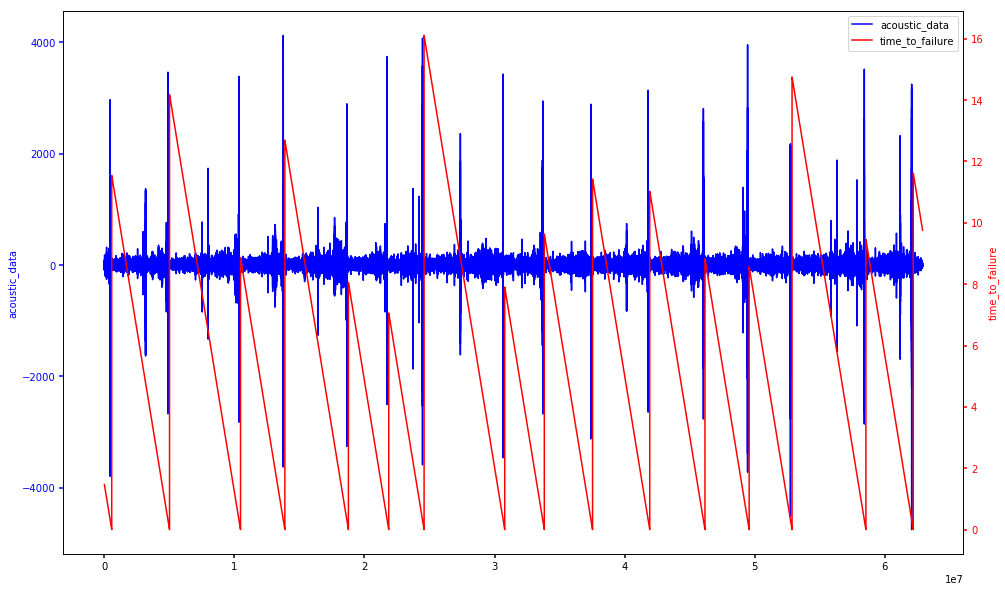

In [9]:
plotSignal(df,steps=10)


### Insights after high level ploting


* If we look at high level it seems we have 16 laboratory earthquakes (time to failure ~0) 
* It seems that just before an laboratory earthquakes,there are huge "peaks" (high fluctuations in relation to all data)
* Between "heavy peaks" we have small fluctuations in relation to the huge "peaks"



# Going deeper


**Lets zoom in the accoustic data tt get some more insights**

### Some zoomed in plot from beginning of data-first 20 miliiion records

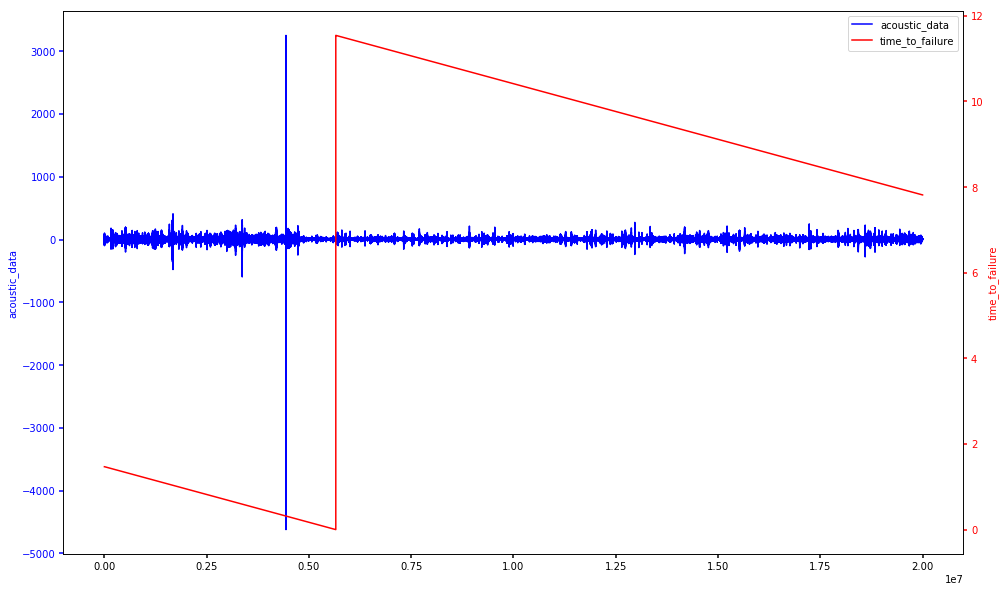

In [10]:
plotSignal(df,toIndex=20000000)


### Some zoomed in plot from middle of data -from 300000000 million record to 320000000 record

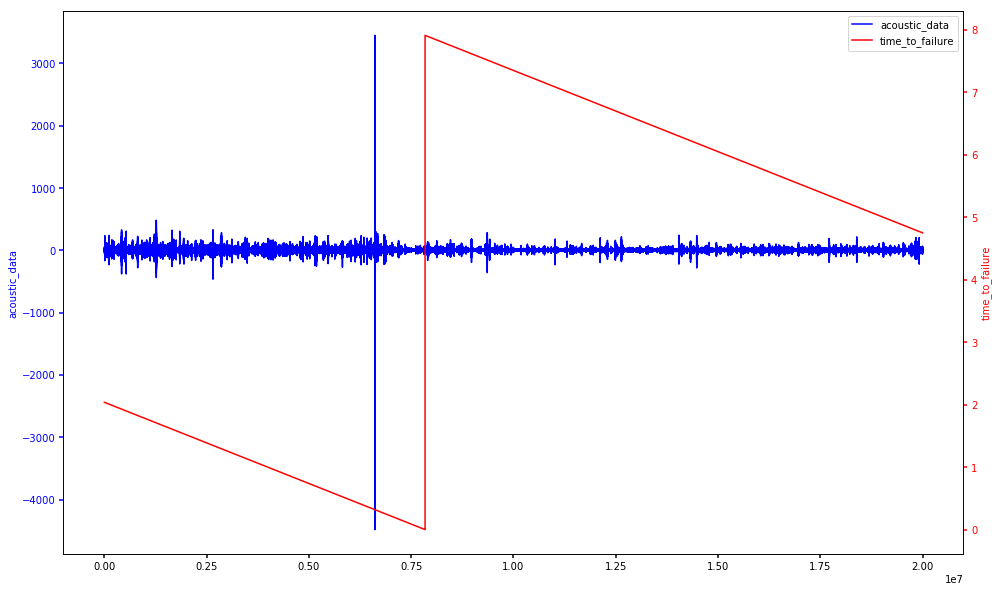

In [11]:
plotSignal(df,fromIndex=300000000,toIndex=320000000)


### Some zoomed in plot from end of data -from 580000000 million record to 600000000 record


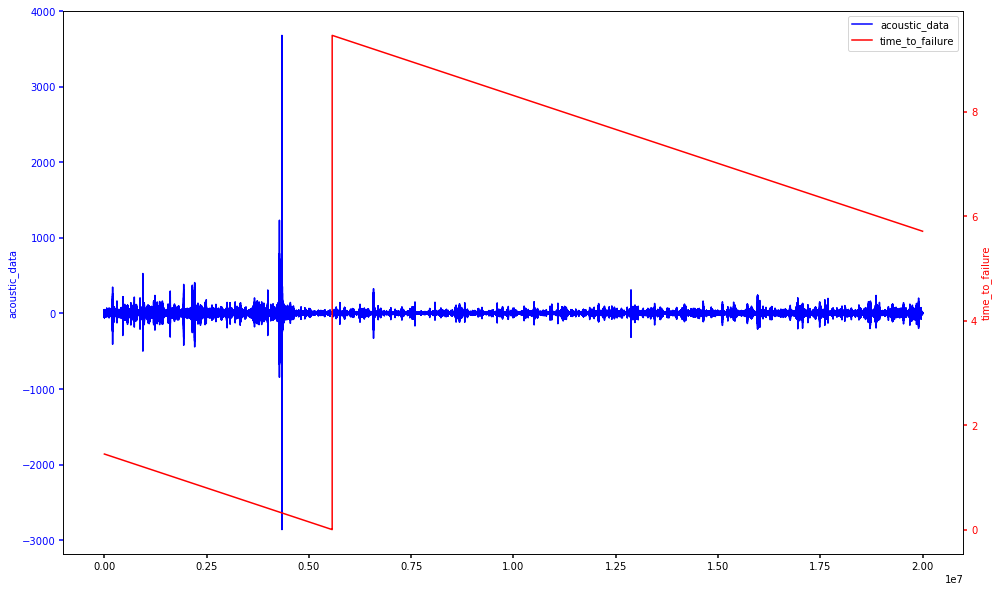

In [12]:
plotSignal(df,fromIndex=580000000,toIndex=600000000)


## Insights after zoomed in plots 
* We see that the "laboratory earthquake" does not occur immediately after the "huge peaks" (high fluctuations)
* Between the "huge peaks" and the "laboratory earthquake" we have some smaller fluctuations


### Ideas and thoughts of what we can do with the data
* The data is represented by chunks of "ups and down"
* We can split data into chunks.
* Try to characterize and analyze the chunks with valuable characterize 
* Define 'range of chunk' that can give us valuable behaviour of "chunk"


# Feature Engineering
* **Range of chunk** - in order to choose a valuable range "range of chunk" we need to consult with an domain expert and define a range that will give us the best value,currently I chose a chunk to be 150000 records just because the test segment come with bulks of 150000
* **Target variable**- our target variable is "time to failure" .similar to the range of chunks, we we need to consult with an domain expert and to see what is the best way to calculate this value from the chunk.Currently I chose the value of "time to failure" of chunks to be the value of last record of chunk


### Chunk features

**We need to consult with an domain expert and define a valuable features,currentlly I chose several types of features of chunk:**

* **basic statsics  features:** max,min,mean,std,percentile, etc...
* **peaks features:** local max count,local min count,local max std,local min std,etc...<br> 
https://en.wikipedia.org/wiki/Maxima_and_minima
* **rolling features:** rolling mean avg,rolling mean std etc...<br>
* **advanced distribution parameters:**  kurtosis,skewness...<br>
https://en.wikipedia.org/wiki/Kurtosis<br>
https://en.wikipedia.org/wiki/Skewness

# Lets define some functions...


In [13]:
"""
The function return all supported features
"""
def getSupportedFeatures():
    return ['MAX','MIN','MEAN','STD','RANGE','LOCAL_MAX_COUNT','LOCAL_MIN_COUNT','LOCAL_MAX_STD','LOCAL_MIN_STD','MEDIAN','P25','P75','P1','P5','P95','P99','KURTOSIS','SKEWNESS','LOCAL_MAX_POS_MEAN','LOCAL_MAX_NEG_MEAN','LOCAL_MIN_POS_MEAN','LOCAL_MIN_NEG_MEAN','LOCAL_MAX_POS_STD','LOCAL_MAX_NEG_STD','LOCAL_MIN_POS_STD','LOCAL_MIN_NEG_STD','ROLLING_MEAN_AVG_500','ROLLING_MEAN_AVG_1000','ROLLING_MEAN_AVG_1500','ROLLING_MEAN_AVG_2000','ROLLING_MEAN_STD_500','ROLLING_MEAN_STD_1000','ROLLING_MEAN_STD_1500','ROLLING_MEAN_STD_2000','ROLLING_STD_AVG_500','ROLLING_STD_AVG_1000','ROLLING_STD_AVG_1500','ROLLING_STD_AVG_2000','ROLLING_STD_STD_500','ROLLING_STD_STD_1000','ROLLING_STD_STD_1500','ROLLING_STD_STD_2000','P10','P20','P30','P40','P60','P70','P80','P90']

In [14]:
"""
The function returns n's percentile of list x
"""
def percentile(x,n):
    return np.percentile(x, n)
"""
The function returns all local max of list x
"""
def getLocalMaxValues(x):
    return x.iloc[argrelextrema(x.values, np.greater)[0]]
"""
The function returns all local min of list x
"""
def getLocalMinValues(x):
    return x.iloc[argrelextrema(x.values, np.less)[0]]
"""
The function returns rolling mean of list x in time window
"""
def getRollingMean(x,window):
    return x.rolling(window).mean()
"""
The function returns rolling std of list x in time window
"""
def getRollingStd(x,window):
    return x.rolling(window).std()

In [15]:
"""
The function gets feature name and chunk values and return the feature value
if feature not supported raises Exception 
"""
def createFeature(featureName,chunkValues):
    if featureName=="MAX":
        return np.max(chunkValues)
    elif featureName=="MIN":
        return np.min(chunkValues)
    elif featureName=="MEAN":
        return np.mean(chunkValues)
    elif featureName=="STD":
        return np.std(chunkValues)
    elif featureName=="RANGE":
        return np.max(chunkValues)-np.min(chunkValues)
    elif featureName=="LOCAL_MAX_COUNT":
        return len(getLocalMaxValues(chunkValues))
    elif featureName=="LOCAL_MIN_COUNT":
        return len(getLocalMinValues(chunkValues))
    elif featureName=="LOCAL_MAX_STD":
        return np.std(getLocalMaxValues(chunkValues))
    elif featureName=="LOCAL_MIN_STD":
        return np.std(getLocalMinValues(chunkValues))
    elif featureName=="LOCAL_MAX_POS_MEAN":
        return np.mean(list(filter(lambda x: x >0, getLocalMaxValues(chunkValues))))
    elif featureName=="LOCAL_MAX_NEG_MEAN":
        return np.mean(list(filter(lambda x: x <0, getLocalMaxValues(chunkValues))))
    elif featureName=="LOCAL_MIN_POS_MEAN":
        return np.mean(list(filter(lambda x: x >0, getLocalMinValues(chunkValues))))
    elif featureName=="LOCAL_MIN_NEG_MEAN":
        return np.mean(list(filter(lambda x: x <0, getLocalMinValues(chunkValues))))
    elif featureName=="LOCAL_MAX_POS_STD":
        return np.std(list(filter(lambda x: x >0, getLocalMaxValues(chunkValues))))
    elif featureName=="LOCAL_MAX_NEG_STD":
        return np.std(list(filter(lambda x: x <0, getLocalMaxValues(chunkValues))))
    elif featureName=="LOCAL_MIN_POS_STD":
        return np.std(list(filter(lambda x: x >0, getLocalMinValues(chunkValues))))
    elif featureName=="LOCAL_MIN_NEG_STD":
        return np.std(list(filter(lambda x: x <0, getLocalMinValues(chunkValues))))
    elif featureName=="MEDIAN":
        return percentile(chunkValues,50)
    elif featureName=="P25":
        return percentile(chunkValues,25)
    elif featureName=="P75":
        return percentile(chunkValues,75)
    elif featureName=="P1":
        return percentile(chunkValues,1)
    elif featureName=="P5":
        return percentile(chunkValues,5)
    elif featureName=="P95":
        return percentile(chunkValues,95)
    elif featureName=="P99":
        return percentile(chunkValues,99)
    elif featureName=="KURTOSIS":
        return kurtosis(chunkValues)
    elif featureName=="SKEWNESS":
        return skew(chunkValues)
    elif featureName=="ROLLING_MEAN_AVG_500":
        return getRollingMean(chunkValues,500).mean()
    elif featureName=="ROLLING_MEAN_AVG_1000":
        return getRollingMean(chunkValues,1000).mean()
    elif featureName=="ROLLING_MEAN_AVG_1500":
        return getRollingMean(chunkValues,1500).mean()
    elif featureName=="ROLLING_MEAN_AVG_2000":
        return getRollingMean(chunkValues,2000).mean()
    elif featureName=="ROLLING_MEAN_STD_500":
        return getRollingMean(chunkValues,500).std()
    elif featureName=="ROLLING_MEAN_STD_1000":
        return getRollingMean(chunkValues,1000).std()
    elif featureName=="ROLLING_MEAN_STD_1500":
        return getRollingMean(chunkValues,1500).std()
    elif featureName=="ROLLING_MEAN_STD_2000":
        return getRollingMean(chunkValues,2000).std()
    elif featureName=="ROLLING_STD_AVG_500":
        return getRollingStd(chunkValues,500).mean()
    elif featureName=="ROLLING_STD_AVG_1000":
        return getRollingStd(chunkValues,1000).mean()
    elif featureName=="ROLLING_STD_AVG_1500":
        return getRollingStd(chunkValues,1500).mean()
    elif featureName=="ROLLING_STD_AVG_2000":
        return getRollingStd(chunkValues,2000).mean()
    elif featureName=="ROLLING_STD_STD_500":
        return getRollingStd(chunkValues,500).std()
    elif featureName=="ROLLING_STD_STD_1000":
        return getRollingStd(chunkValues,1000).std()
    elif featureName=="ROLLING_STD_STD_1500":
        return getRollingStd(chunkValues,1500).std()
    elif featureName=="ROLLING_STD_STD_2000":
        return getRollingStd(chunkValues,2000).std()
    elif featureName=="P10":
        return percentile(chunkValues,10)
    elif featureName=="P20":
        return percentile(chunkValues,20)
    elif featureName=="P30":
        return percentile(chunkValues,30)
    elif featureName=="P40":
        return percentile(chunkValues,40)
    elif featureName=="P60":
        return percentile(chunkValues,60)
    elif featureName=="P70":
        return percentile(chunkValues,70)
    elif featureName=="P80":
        return percentile(chunkValues,80)
    elif featureName=="P90":
        return percentile(chunkValues,90)
    else:
        raise Exception("Not Supported featureName :"+featureName)  

In [16]:
"""
The function gets chunk values and features list and return record of feature for the chunks values
"""
def convertRawDataToFeatures(chunkValues,features):
    chunkDf = pd.DataFrame(columns=features)
    dictRes={}
    for cur_feature in features:
        cur_feature_res=createFeature(cur_feature,chunkValues)
        dictRes[cur_feature]=cur_feature_res
    
    chunkDf = chunkDf.append(dictRes, ignore_index=True)
    return chunkDf

In [17]:
"""
The function gets chunk values and features list and return record of feature for the chunks values with the target value
"""
def createChunkTrainRecord(chunk,features):
    trainRecord=convertRawDataToFeatures(chunk['acoustic_data'],features)
    trainRecord['time_to_failure']=chunk['time_to_failure'].values[-1]
    return trainRecord

In [18]:
"""
The functions gets data frame and n,return lists of data frame each of size n
"""
def splitDfToChunks(df,n):
    list_df = [df[i:i+n] for i in range(0,df.shape[0],n)]
    return list_df

In [19]:
"""
The functions gets data frame ,features list,and n.
Returns training set with the features,with chunk size=n
"""
def createTrainSet(df,features,n=150000):
    list_df=splitDfToChunks(df,n)
    chunksOfN=[createChunkTrainRecord(cur_df,features) for cur_df in list_df if cur_df.shape[0]==n]
    chunksDf = pd.concat(chunksOfN).reset_index(drop=True)
    return chunksDf
 

### Creating training set with chunk size=150000

In [20]:

trainDf=createTrainSet(df,getSupportedFeatures(),150000)

In [21]:
trainDf.shape

(4194, 51)

### We have a training set with 4194 chunks (records) ,50 features and 1 target variable 

In [22]:
trainDf.head(10)

,MAX,MIN,MEAN,STD,RANGE,LOCAL_MAX_COUNT,LOCAL_MIN_COUNT,LOCAL_MAX_STD,LOCAL_MIN_STD,MEDIAN,...,ROLLING_STD_STD_2000,P10,P20,P30,P40,P60,P70,P80,P90,time_to_failure
0,104.0,-98.0,4.88411333333333352869,5.10108912689132321105,202.0,31523.0,31550.0,4.12710477424439847738,4.10270265818081014686,5.0,...,2.56813247984298920201,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.43079718589999993483
1,181.0,-154.0,4.72576666666666689309,6.58880181916425655686,335.0,31292.0,31367.0,5.04641045427233692067,4.90518938879842014700,5.0,...,4.20742621866866528535,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.39149889310000007825
2,140.0,-106.0,4.90639333333333294007,6.96737380882894452583,246.0,30706.0,30694.0,5.45772548559269310431,5.41723804019151167211,5.0,...,3.96194118165013575705,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.35319609469999990736
3,197.0,-199.0,4.90223999999999993094,6.92228211279103167186,396.0,31320.0,31330.0,5.38830474641700796212,5.19742515041530506181,5.0,...,4.59108732982451872573,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.31379780190000006179
4,145.0,-126.0,4.90871999999999975017,7.30108585268428900150,271.0,31302.0,31231.0,5.40683075054823536476,5.53003645515422093126,5.0,...,4.92321543971809383322,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.27439950909999999418
5,142.0,-144.0,4.91351333333333339937,5.43409299912649323971,286.0,31243.0,31281.0,4.37833401144411737960,4.37961060899569964988,5.0,...,2.67813977955408777376,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.23609671069999982329
6,120.0,-78.0,4.85566000000000030923,5.68780443560899318101,198.0,31042.0,31135.0,4.59150396991750220366,4.56498707224447652919,5.0,...,2.74654611748807342408,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.19679841789999996671
7,139.0,-134.0,4.50542666666666669073,5.85449205464962219025,273.0,31692.0,31648.0,4.45682459473106362680,4.56059964022949593243,5.0,...,3.49324701549222726982,0.0,2.0,3.0,4.0,5.0,6.0,7.0,9.0,1.15849561950000001787
8,168.0,-156.0,4.71783333333333310122,7.78961714755966472268,324.0,30363.0,30349.0,6.02294290223875794510,5.93052149098309122621,5.0,...,4.91135238729434675520,-1.0,1.0,3.0,4.0,6.0,7.0,8.0,10.0,1.11909732669999995025
9,152.0,-126.0,4.73095999999999961005,6.89043618443225458492,278.0,30921.0,30793.0,5.35102487474325272387,5.25844109694045069858,5.0,...,4.21299891286577210536,0.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0,1.07969903390000010468


# Feature selection (Remove highly correlate features)

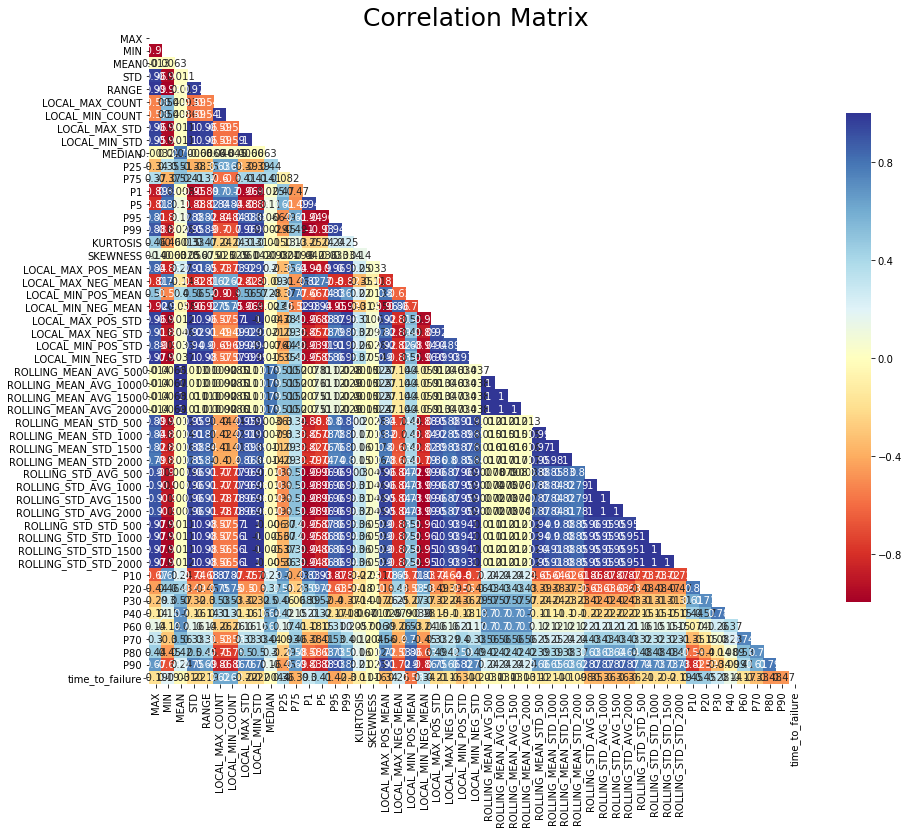

In [23]:
df_corr=trainDf.corr()
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlation Matrix',fontsize=25)
sns.heatmap(df_corr,vmax=1.0,square=True,cmap="RdYlBu",
linecolor='w',annot=True,mask=mask,cbar_kws={"shrink": .75})

**We can see in the dark blue cells and the dark red cells high correlation between features**

**Remove high correlate features:**<br>Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".<br>


**Some advantages of removing high correlated features :**
* Decrease harmful bias
* Make the learning algorithm faster
* Interpretability of your model (Simpler is better usually)


### We will Remove features that have  ABS(corr)>0.9 with some other feature


In [24]:
"""
The function get df and threshold,return features that has abs(corr)>throshold
""" 

def getHighCorrFeatures(df, corrThreshold):
    highCorrFeatures = set()  # Set of all the names of correlated columns
    corr_df = df.corr()
    for feature1 in range(len(corr_df.columns)):
        for feature2 in range(feature1):
            if abs(corr_df.iloc[feature1, feature2]) > corrThreshold: # we are interested in absolute coeff value
                colname = corr_df.columns[feature1]  # getting the name of high corr column
                highCorrFeatures.add(colname)
    return highCorrFeatures


In [25]:
corr_features = getHighCorrFeatures(trainDf.drop("time_to_failure",axis=1), 0.9)
print('correlated features: ')
print('--------------------- ')
print(corr_features)
print('number of correlated features: ', len(set(corr_features)) )

correlated features: 
--------------------- 
{'ROLLING_STD_AVG_2000', 'LOCAL_MAX_POS_MEAN', 'LOCAL_MIN_COUNT', 'LOCAL_MAX_STD', 'P99', 'P95', 'ROLLING_MEAN_AVG_1000', 'ROLLING_STD_STD_1000', 'MIN', 'ROLLING_MEAN_STD_1000', 'ROLLING_MEAN_AVG_1500', 'LOCAL_MAX_NEG_STD', 'ROLLING_STD_STD_2000', 'ROLLING_STD_AVG_500', 'ROLLING_MEAN_AVG_2000', 'ROLLING_MEAN_STD_500', 'P90', 'P5', 'P10', 'ROLLING_STD_AVG_1500', 'ROLLING_STD_STD_1500', 'ROLLING_MEAN_STD_1500', 'ROLLING_MEAN_STD_2000', 'ROLLING_STD_AVG_1000', 'LOCAL_MIN_STD', 'LOCAL_MIN_NEG_STD', 'ROLLING_MEAN_AVG_500', 'LOCAL_MIN_NEG_MEAN', 'LOCAL_MAX_POS_STD', 'ROLLING_STD_STD_500', 'RANGE', 'LOCAL_MIN_POS_STD', 'P1', 'STD', 'LOCAL_MIN_POS_MEAN'}
number of correlated features:  35


**Total high correlated features :35**

In [26]:
#removing high correlated features
trainDf=trainDf.drop(labels=corr_features, axis=1)

In [27]:
trainDf.shape

(4194, 16)

### After removing high correlated features we have a training set with 4194 chunks (records) ,15 features and 1 target variable 

# Establish a baseline

**When comparing various machine learning algorithms, baseline provides a point of reference to compare.
We will create a naive baseline model and then try to make more complex solutions in order to get a better result.
Our baseline model will simple linear regression and the predicted value will be based on chunk median.**<br>


In [28]:
y = trainDf["time_to_failure"]
X = trainDf[["MEDIAN"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=50)
lm = LinearRegression()
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
MSE=metrics.mean_squared_error(y_test, prediction)
RSQUARED=metrics.explained_variance_score(y_test, prediction)

print ("Baseline MSE:",MSE)
print ("Best RSQUARED:",RSQUARED)


Baseline MSE: 12.0586339409
Best RSQUARED: 0.000108728193549


#### The basline gave us MSE:12.32,RSQUARED:0.000108728193549


# Lets try to improve the baseline model

In [29]:
def getAlgorithmName(x):
    return str(x).split('(')[0]

"""
The function runs grids with specific algorithm-->print best models MSE and parameters
"""  
def runGridSearch(df,algorithm,param_grids,cv_size=5,normalized=False):
    

    X = df.drop("time_to_failure",axis=1)
    y = df["time_to_failure"]
    if normalized==True:
        scaler = StandardScaler()
        scaler.fit(X)
        X=pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=50)
    grid = GridSearchCV(algorithm, param_grids, cv=cv_size)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_
    y_pred = model.predict(X_test)
    MSE=metrics.mean_squared_error(y_test, y_pred)
    RSQUARED=metrics.explained_variance_score(y_test, y_pred)
    algorithmName=getAlgorithmName(algorithm)
    print("Running "+ algorithmName+" algorithm ,normalized=",normalized)
    print("-------------------------------------------------------------")
    print ("Best MSE:",MSE)
    print ("Best RSQUARED:",RSQUARED)
    print ("Best parameters:", grid.best_params_)

# Compare several machine learning models  using gridsearch

### Running RandomForestRegressor using gridsearch

In [30]:


estimator = RandomForestRegressor(random_state=500)
param_grids = {
            "n_estimators" : [50,100,200],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False],
        }
runGridSearch(trainDf,estimator,param_grids,5)

Running RandomForestRegressor algorithm ,normalized= False
-------------------------------------------------------------
Best MSE: 6.47345422801
Best RSQUARED: 0.462292973312
Best parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 200}


### Running KNeighborsRegressor using gridsearch

In [31]:


estimator = neighbors.KNeighborsRegressor()

param_grids = {'n_neighbors':[5,7,9,11,13],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

runGridSearch(trainDf,estimator,param_grids,5)

Running KNeighborsRegressor algorithm ,normalized= False
-------------------------------------------------------------
Best MSE: 7.08420055276
Best RSQUARED: 0.41081078722
Best parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 13}


### Running SVR using gridsearch

In [32]:
estimator = SVR(kernel='rbf')
param_grids={
            'C': [0.001, 0.01, 0.1, 1, 10],
            'gamma': [0.001, 0.01, 0.1, 1]
        }
runGridSearch(trainDf,estimator,param_grids,5)

Running SVR algorithm ,normalized= False
-------------------------------------------------------------
Best MSE: 8.30671697786
Best RSQUARED: 0.313784964187
Best parameters: {'C': 1, 'gamma': 0.001}


# Try to improve -Compare several machine learning models with using gridsearch with StandardScaler normalization

### Running RandomForestRegressor using gridsearch with StandardScaler normalization

In [33]:

estimator = RandomForestRegressor(random_state=500)
param_grids = {
            "n_estimators" : [50,100,200],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False],
        }
runGridSearch(trainDf,estimator,param_grids,5,True)

Running RandomForestRegressor algorithm ,normalized= True
-------------------------------------------------------------
Best MSE: 6.47046550752
Best RSQUARED: 0.462566639566
Best parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 200}


### Running KNeighborsRegressor using gridsearch with StandardScaler normalization

In [34]:
estimator = neighbors.KNeighborsRegressor()

param_grids = {'n_neighbors':[5,7,9,11,13],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

runGridSearch(trainDf,estimator,param_grids,5,True)

Running KNeighborsRegressor algorithm ,normalized= True
-------------------------------------------------------------
Best MSE: 6.5689004418
Best RSQUARED: 0.453636870176
Best parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 13}


### Running SVR using gridsearch with StandardScaler normalization

In [35]:
estimator = SVR(kernel='rbf')
param_grids={
            'C': [0.001, 0.01, 0.1, 1, 10],
            'gamma': [0.001, 0.01, 0.1, 1]
        }

runGridSearch(trainDf,estimator,param_grids,5,True)

Running SVR algorithm ,normalized= True
-------------------------------------------------------------
Best MSE: 6.24232153686
Best RSQUARED: 0.484538697028
Best parameters: {'C': 10, 'gamma': 0.01}


#### The model that gives us best results:
####  Normallized SVR
#### Params:{'C': 10, 'gamma': 0.01}
#### Best MSE: 6.24232153686
#### Best RMSE: 0.484538697028



# Train chosen model on training set and fitting StandardScaler on training set

In [36]:
finalModel = SVR(kernel='rbf',C=10,gamma=0.01)
X = trainDf.drop("time_to_failure",axis=1)
y = trainDf["time_to_failure"]
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
finalModel.fit(X, y)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [37]:
df_features = list(trainDf.columns[:-1])


In [38]:
"""
The functions gets seg_id,reads the relevant test file and predicts time_to_failure
"""
def predictTestFileValues(seg_id):
    cur_seg_df = pd.read_csv(os.getcwd()+'/test/' + seg_id + '.csv')
    x_test_record=convertRawDataToFeatures(cur_seg_df.acoustic_data,df_features)
    x_test_record_transformed=pd.DataFrame(scaler.transform(x_test_record), columns=X.columns)
    seg_id_prediction=finalModel.predict(x_test_record_transformed)[0]
    return seg_id_prediction

**Filling submission with predicted values**

In [39]:
submission= pd.read_csv('sample_submission.csv', index_col='seg_id')
##for each predict value 
for seg_id in submission.index:
    submission.loc[seg_id,'time_to_failure']=predictTestFileValues(seg_id)

In [40]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.88325542525271716343
seg_0012b5,5.10713024637744616996
seg_00184e,6.30481804349790486697
seg_003339,8.54776047854839049478
seg_0042cc,6.31580763905476949560


In [41]:
submission.to_csv('submission.csv')